In [1]:
import logging
import os
import pandas as pd
import numpy as np

def dummy(doc):
    return doc
Dataset = "pubmed"

# read data from all file 
PATH = '../Data'
# print log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# parameters
cutoff = 2

In [2]:
# collect cleaned tokenized data for vectorization
import com_func
from statistics import mean 

# read all files 
def readallfile(filepath):
    documents = []
    with open(filepath, 'r', encoding = 'utf8') as f:
        for line in f:
            items = line.split("\t")
            paperID = items[0]
            title = items[1].lower()
            keywords = items[2].lower()
            mesh = items[3].lower()
            abstract = items[4].lower()
            content = title+" "+keywords+" "+mesh+" "+abstract
            # keyword and mesh
            key_mesh = keywords+" "+mesh
            # title and abstract
            title_abstract = title+" "+abstract
            # title keywords mesh
            title_key_mesh = title+" "+key_mesh
            # abstract keywords mesh
            abstract_key_mesh = abstract+" "+key_mesh
            # all feature combined
            content = title+" "+keywords+" "+mesh+" "+abstract
            paper_text_content = {"paperID": paperID, "title":title, "abstract": abstract, "keywords_mesh":key_mesh,
                                  "title_abstract":title_abstract,"title_key_mesh":title_key_mesh, 
                                  "abstract_key_mesh":abstract_key_mesh, "textual":content}
            documents.append(paper_text_content)
    f.close()
    print("Done loading files, total ", len(documents), " papers")
    documents = pd.DataFrame(documents)
    return documents

documents = readallfile(PATH+"/"+Dataset+"/id_textual_combined.txt")

Done loading files, total  3151504  papers


In [3]:
# train the model
def train_d2v_model(formated_doc, alg=0):
    cores = multiprocessing.cpu_count()
    # train model
    # size is dimension of vector return, dm defines training algorithm, when dm = 1 is distributed memory (PV-DM),
    # pv-dbow is better than pv-md
    # when dm = 0 is distributed bag of words (PV-DBOW), 
    # sample is threshold for configuring which higher-frequency words are randomly downsampled, 
    # min_count is ignore threshold (Ignores all words with total frequency lower than min_count)
    model = gensim.models.Doc2Vec(formated_doc, dm=alg, vector_size=100, negative=5, window=5, min_count=cutoff,
                                  epochs=20, sample=1e-3, workers=cores)
    return model

In [4]:
import unicodedata
import string
valid_filename_chars = "-_.,() %s%s" % (string.ascii_letters, string.digits)
char_limit = 255
def clean_filename(filename, whitelist=valid_filename_chars, replace=' '):
    # replace spaces
    for r in replace:
        filename = filename.replace(r,'_')
    
    # keep only valid ascii chars
    cleaned_filename = unicodedata.normalize('NFKD', filename).encode('ASCII', 'ignore').decode()
    
    # keep only whitelisted chars
    cleaned_filename = ''.join(c for c in cleaned_filename if c in whitelist)
    if len(cleaned_filename)>char_limit:
        print("Warning, filename truncated because it was over {}. Filenames may no longer be unique".format(char_limit))
    return cleaned_filename[:char_limit]

2019-01-10 14:52:16,338 : INFO : 'pattern' package not found; tag filters are not available for English


Feature:  keywords_mesh average token length: 19.232518822758912
max token length:  1638
min token length:  0
3151504
[['cross', 'protection', 'hemagglutination', 'inhibition', 'test', 'immunity', 'influenza', 'microneutralization', 'test', 'neutralization', 'test'], ['epidemiology', 'healthcare', 'associated', 'infection', 'rotavirus', 'vaccination', 'adolescent', 'child', 'child', 'preschool', 'community', 'acquired', 'infections', 'cross', 'infection', 'female', 'gastroenteritis', 'hospitals', 'humans', 'infant', 'infant', 'newborn', 'male', 'prevalence', 'rotavirus', 'infections', 'rotavirus', 'vaccines', 'united', 'kingdom', 'vaccination']]
['27406695', '26876744']


/home/gao137/intel/intelpython3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


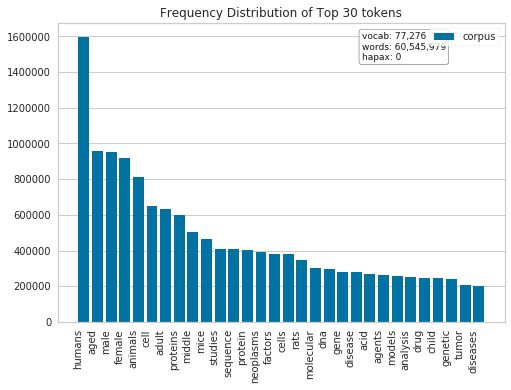

(3151504, 77276)
Feature:  textual average token length: 133.1971477745229
max token length:  1783
min token length:  0
3151504
[['comparison', 'hemagglutination', 'inhibition', 'neutralization', 'assays', 'characterizing', 'immunity', 'seasonal', 'influenza', 'cross', 'protection', 'hemagglutination', 'inhibition', 'test', 'immunity', 'influenza', 'microneutralization', 'test', 'neutralization', 'test', 'serum', 'antibody', 'influenza', 'used', 'identify', 'past', 'exposure', 'measure', 'current', 'immune', 'status', 'two', 'common', 'methods', 'measuring', 'hemagglutination', 'inhibition', 'assay', 'hi', 'viral', 'neutralization', 'assay', 'nt', 'systematically', 'compared', 'large', 'number', 'influenza', 'viruses', 'total', 'study', 'participants', 'near', 'guangzhou', 'china', 'enrolled', 'provided', 'serum', 'hi', 'nt', 'assays', 'performed', 'historic', 'recently', 'circulating', 'strains', 'seasonal', 'influenza', 'compared', 'titers', 'using', 'spearman', 'correlation', 'fit',

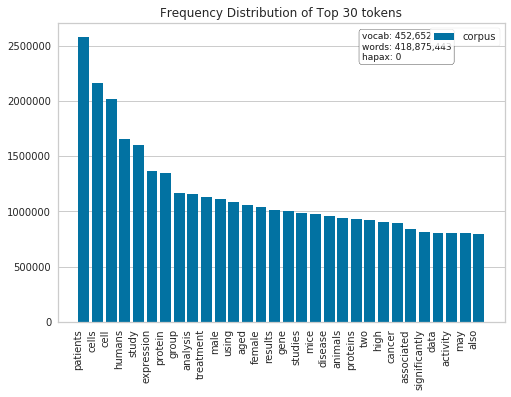

(3151504, 452652)


In [5]:
import matplotlib.pyplot as plt
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import pickle
# convert tokenized text to TaggedDocument
import gensim
import multiprocessing
from gensim.models.doc2vec import TaggedDocument

cores = multiprocessing.cpu_count()

textual_features = ["title", "abstract", "keywords_mesh", "textual"]
allpid = documents["paperID"].tolist()
for feature in textual_features:
    # unprocess pram cutoff= 1 (stopword=False, word_min_length = 1,only_letter = False)
    cleaned_feature, feature_token_size = com_func.clean_batch_of_raw(documents[feature], 
                                                                      stopword=True, 
                                                                      word_min_length = 2,
                                                                      only_letter = True)
    print("Feature: ",feature, "average token length:", np.sum(feature_token_size)/len(feature_token_size))
    print("max token length: ", max(feature_token_size))
    print("min token length: ", min(feature_token_size))
    # collect some statistic
    print(len(cleaned_feature))
    print(cleaned_feature[:2])
    print(allpid[:2])
    
    #axes = plt.gca()
    vectorizer = CountVectorizer(min_df = cutoff, analyzer='word', tokenizer=dummy,preprocessor=dummy)
    count_matrix = vectorizer.fit_transform(cleaned_feature)
    features = vectorizer.get_feature_names()
    visualizer = FreqDistVisualizer(features=features, n=30, orient="v")
    visualizer.fit(count_matrix)
    visualizer.set_title("Frequency distribution before data preprocessing")
    save_path = feature + "_token_freq_dist_before_preprocess_sample=3m.png"
    visualizer.finalize()
#     visualizer.poof(outpath=save_path, dpi=300)
    visualizer.poof()
    print(count_matrix.shape)
    
#     # convert raw text to numerical feature vectors (TF)
#     # unigram are used
#     tf_vectorizer = TfidfVectorizer(use_idf=False, sublinear_tf=True, norm="l2",stop_words = None, min_df=cutoff,
#                                     analyzer='word', tokenizer=dummy,preprocessor=dummy, max_features = 50000)
#     # train a dictionary to build a tf with log normalization
#     tf_matrix = tf_vectorizer.fit_transform(cleaned_feature)
#     print(len(tf_vectorizer.vocabulary_))
#     print(tf_matrix.shape)
#     print(tf_matrix[0].nonzero())
#     print(tf_matrix[0].toarray())
#     print(tf_matrix[0])
#     # save the model for log normalized tf
#     modelSaveDir = "../Data/"+Dataset+"/models/tf/"+feature+"_sample=3m/"
#     if not os.path.exists(modelSaveDir):
#         os.makedirs(modelSaveDir)
#     pickle.dump(tf_vectorizer, open(modelSaveDir+"log_normalized_tf_model.pickle", "wb"))
#     pickle.dump(tf_matrix, open(modelSaveDir+"tf_features.pickle", "wb"))
#     pickle.dump(allpid, open(modelSaveDir+"feature_pid.pickle", "wb"))
    
    
#     # calculate tf-idf
#     # tf = sublinear tf, 1+log(tf) if tf >0, or 0. idf = (log(1+N)/df(t,d,C)) + 1
#     # df(d,t,C) means number of document d contain term t in collection C
#     # Each row is normalized to have unit Euclidean norm 
#     # reference to http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
#     tfidf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, sublinear_tf=True, norm="l2", min_df=cutoff,
#                                        max_features = 50000, analyzer='word', tokenizer=dummy,preprocessor=dummy, 
#                                        stop_words = None)
#     tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_feature)
#     print(len(tfidf_vectorizer.vocabulary_))
#     print(tfidf_matrix.shape)
#     # save model
#     modelSaveDir = "../Data/"+Dataset+"/models/tf_idf/"+feature+"_sample=3m/"
#     if not os.path.exists(modelSaveDir):
#         os.makedirs(modelSaveDir)
#     pickle.dump(tfidf_vectorizer, open(modelSaveDir+"tf_idf_Vectorizer.pickle", "wb"))
#     pickle.dump(tfidf_matrix, open(modelSaveDir+"tf_idf_trained_features.pickle", "wb"))
#     pickle.dump(allpid, open(modelSaveDir+"feature_pid.pickle", "wb"))
    
    
#     # LSA
#     from sklearn.decomposition import TruncatedSVD
#     svd = TruncatedSVD(n_components=100)
#     final_lsa_Matrix = svd.fit_transform(tfidf_matrix)
#     print(final_lsa_Matrix.shape)
#     # save the trained LSA
#     modelSaveDir = "../Data/"+Dataset+"/models/lsa/"+feature+"_sample=3m/"
#     if not os.path.exists(modelSaveDir):
#         os.makedirs(modelSaveDir)
#     pickle.dump(final_lsa_Matrix, open(modelSaveDir+"lsa_Matrix.pickle", "wb"))
#     pickle.dump(allpid, open(modelSaveDir+"feature_pid.pickle", "wb"))
    
    
#     # doc2vec
#     formated_doc = []
    
#     for paper in zip(allpid, cleaned_feature):
#         formated_doc.append(TaggedDocument(words = paper[1], tags = [paper[0]]))
#     print(formated_doc[:3])
#     print(len(formated_doc))
    
#     # pv_dbow
#     model_pv_dbow = train_d2v_model(formated_doc,alg=0)
#     # save model
#     newfileDir = "../Data/"+Dataset+"/models/doc2v/"+feature+"_sample=3m/pv_dbow/"
#     if not os.path.exists(newfileDir):
#         os.makedirs(newfileDir)
#     modelname = model_pv_dbow.__str__()
#     print("Saving model ", modelname)
#     model_pv_dbow.save(newfileDir+modelname)
#     print("Done")
#     model_pv_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
#     # pv_dm
#     model_pv_dm = train_d2v_model(formated_doc,alg=1)
#     print(model_pv_dm.__str__())
#     print(clean_filename(model_pv_dm.__str__()))
    
#     # save model
#     newfileDir = "../Data/"+Dataset+"/models/doc2v/"+feature+"_sample=3m/pv_dm/"
#     if not os.path.exists(newfileDir):
#         os.makedirs(newfileDir)
#     modelname = clean_filename(model_pv_dm.__str__())
#     print("Saving model ", newfileDir+modelname)
#     model_pv_dm.save(newfileDir+modelname)
#     print("Done")
#     model_pv_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [ ]:
sample=0.01 downsamples 0 most-common words
sample=0.001 downsamples 13 most-common words
sample=0.0001 downsamples 678 most-common words